Thermal Convection
======

This example solves 2D dimensionless isoviscous thermal convection with a specified Rayleigh number (starts with $10^5$).


In [1]:
import underworld as uw
from underworld import function as fn
import glucifer
import math

/opt/spack/opt/spack/darwin-highsierra-x86_64/clang-9.0.0-apple/py-h5py-2.7.1-cjcvupm2zgsrtujexr66zjbyzpqekfdu/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Setup parameters
-----

In [5]:
# Set number of dimensions.
dim = 2

# Set simulation box size.
boxHeight = 1.0
boxLength = 1.0

# Set the resolution.
resX = 32
resY = 32


# Set min/max temperatures.

tempMin = 0.0
tempMax = 1.0

Create mesh and variables
------

The mesh is used for solving the equations at a reasonable number of points - the velocity and pressure are unknowns and, for complicated technical reasons, have to be solved on two different (nested) meshes. "Q1/dQ0" produces a primary mesh with element type Q1 and a sub-mesh with elements type dQ0. Q1 elements have node points at the element corners, dQ0 elements have a single node at the elements centre.

In [6]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (resX, resY), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (boxLength, boxHeight))

In [7]:
mesh.add_variable

<bound method FeMesh_Cartesian.add_variable of <underworld.mesh._mesh.FeMesh_Cartesian object at 0x108fde610>>

Create mesh variables.  Note the pressure field uses the sub-mesh. 

In [8]:
velocityField       = mesh.add_variable( nodeDofCount=dim )
temperatureField    = mesh.add_variable( nodeDofCount=1 )
temperatureDotField = mesh.add_variable( nodeDofCount=1 )
pressureField       = mesh.subMesh.add_variable( nodeDofCount=1 )


# Initialise values

velocityField.data[:]       = [0.0, 0.0]
pressureField.data[:]       = 0.0
temperatureDotField.data[:] = 0.0

Set up material parameters and functions
-----

Set functions for viscosity, density and buoyancy force. These functions and variables only need to be defined at the beginning of the simulation, not each timestep.

In [9]:
# Set viscosity to be a constant.
viscosity = 1.

# Rayleigh number.
Ra = 1.0e5

# Construct a buoyancy force function.
buoyancyFn = Ra * temperatureField

# Define a vertical unit vector using a python tuple (this will be automatically converted to a function).
z_hat = ( 0.0, 1.0 )

# Now create a buoyancy force vector using the density and the vertical unit vector. 

buoyancyForceFn = buoyancyFn * z_hat

Create initial & boundary conditions
----------

Set a sinusoidal perturbation in the temperature field to seed the onset of convection.

In [10]:
pertStrength = 0.2
deltaTemp = tempMax - tempMin
for index, coord in enumerate(mesh.data):
    pertCoeff = math.cos( math.pi * coord[0] ) * math.sin( math.pi * coord[1] )
    temperatureField.data[index] = tempMin + deltaTemp*(boxHeight - coord[1]) + pertStrength * pertCoeff
    temperatureField.data[index] = max(tempMin, min(tempMax, temperatureField.data[index]))



Set top and bottom wall temperature boundary values.

In [11]:
for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = tempMax
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = tempMin

Construct sets for ``I`` (vertical) and ``J`` (horizontal) walls. Note both sets contain the corners nodes of the domain.

In [12]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]

Create Direchlet, or fixed value, boundary conditions. More information on setting boundary conditions is found in the **06_Systems.ipynb** user guide.

In [13]:
# 2D velocity vector can have two Dirichlet conditions on each vertex, 
# v_x is fixed on the iWalls (vertical), v_y is fixed on the jWalls (horizontal)
freeslipBC = uw.conditions.DirichletCondition( variable        = velocityField, 
                                               indexSetsPerDof = (iWalls, jWalls) )

# Temperature is held constant on the jWalls
tempBC     = uw.conditions.DirichletCondition( variable        = temperatureField, 
                                               indexSetsPerDof = (jWalls,) )

**Plot initial conditions for temperature**



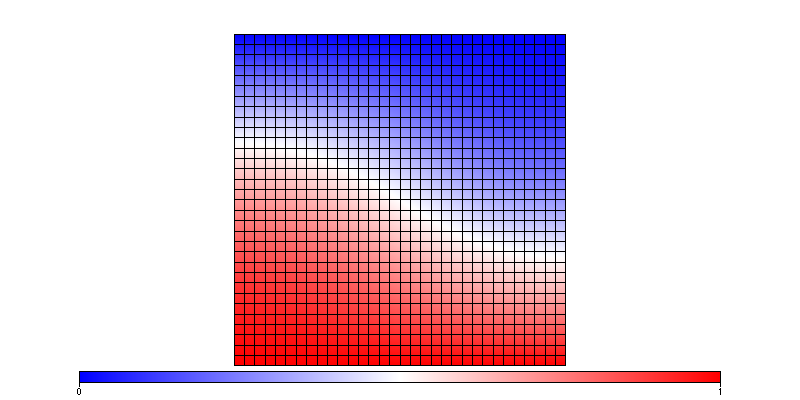

In [14]:
figtemp = glucifer.Figure( figsize=(800,400) )
figtemp.append( glucifer.objects.Surface(mesh, temperatureField, colours="blue white red") )
figtemp.append( glucifer.objects.Mesh(mesh) )
figtemp.show()

System setup
-----

**Setup a Stokes system**

Underworld uses the Stokes system to solve the [incompressible Stokes equations](https://en.wikipedia.org/wiki/Navier%E2%80%93Stokes_equations).  

In [15]:
stokesPIC = uw.systems.Stokes( velocityField = velocityField, 
                               pressureField = pressureField,
                               conditions    = [freeslipBC,],
                               fn_viscosity   = viscosity, 
                               fn_bodyforce   = buoyancyForceFn )

# get the default stokes equation solver
solver = uw.systems.Solver( stokesPIC )

**Set up the advective diffusive system**

Underworld uses the AdvectionDiffusion system to solve the temperature field given heat transport through the velocity field. More information on the advection diffusion equation can be found [here](https://en.wikipedia.org/wiki/Convection%E2%80%93diffusion_equation).

In [16]:
advDiff = uw.systems.AdvectionDiffusion( phiField       = temperatureField, 
                                         phiDotField    = temperatureDotField, 
                                         velocityField  = velocityField, 
                                         fn_diffusivity = 1.0, 
                                         conditions     = [tempBC,] )

Main time stepping loop
-----
Time and steps are initialised to zero. 

Note: we would like to be able to calculate and store the relevant variables which we will need to observe the time-evolution of the computation. We need either to store this in an array (or list), or we need to write the data to a file.  Note also that we have to be careful if we are running in parallel as the raw arrays are only local and will not give max, min or average values relevant to the calculation as a whole.

In [17]:
time = 0.
step = 0
steps_end = 100

while step < steps_end:
    # Solve for the velocity field given the current temperature field.
    solver.solve()
    # Retrieve the maximum possible timestep for the AD system.
    dt = advDiff.get_max_dt()
    if step == 0:
        dt = 0.
    # Advect using this timestep size   
    
    advDiff.integrate(dt)
    step += 1

**Plot final temperature and velocity field**


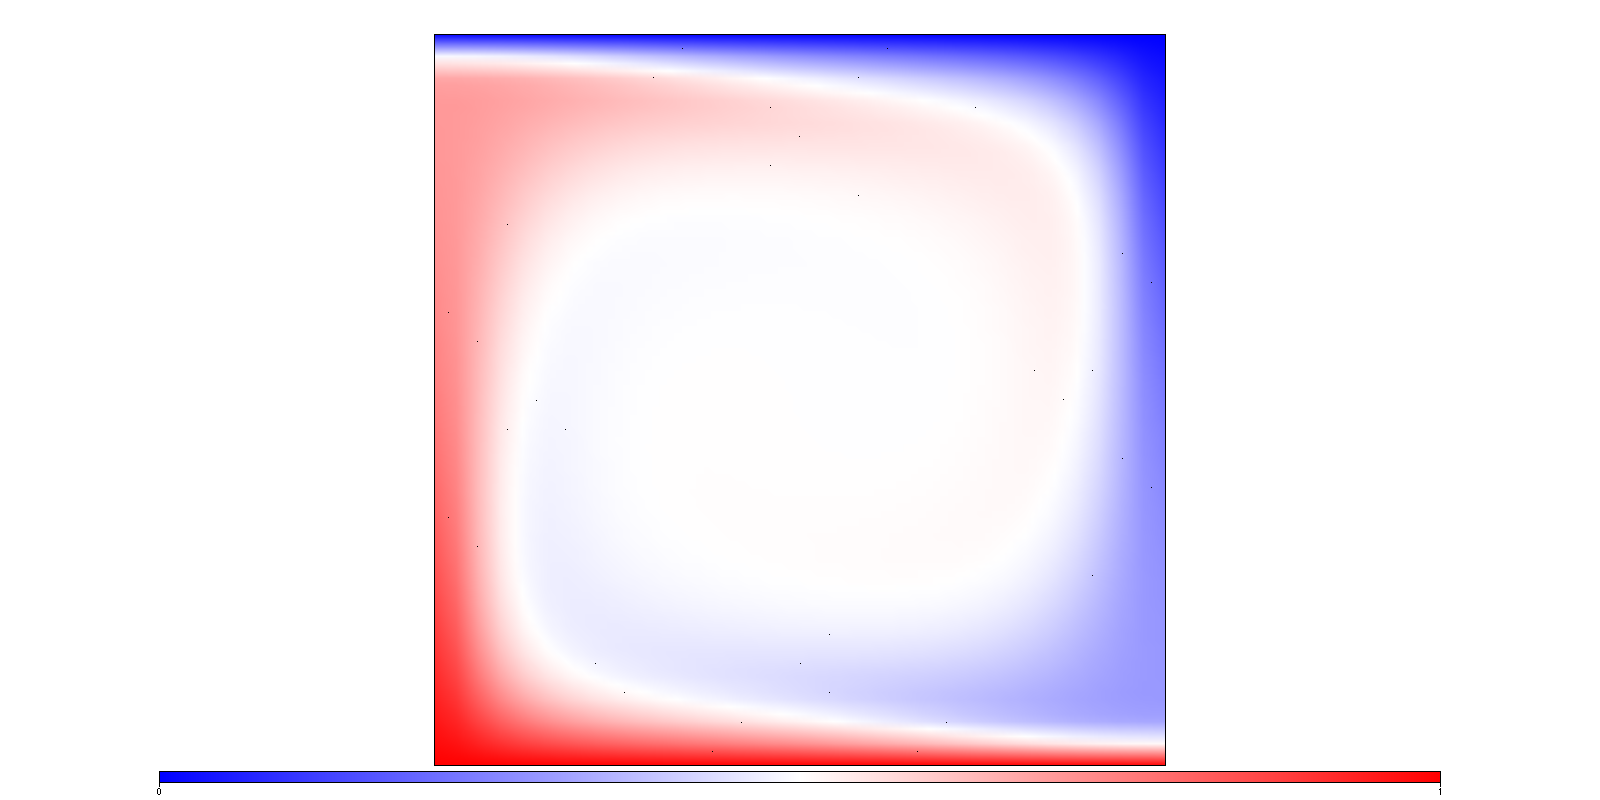

In [21]:
# plot figure

# How to get the maximum velocity values. Note the middle step !

fn_minmaxV = fn.view.min_max((velocityField), fn_norm=fn.math.dot(velocityField,velocityField))
fn_minmaxV.evaluate(mesh)
maxV = fn_minmaxV.max_global()

figtemp = glucifer.Figure( figsize=(1600,800) )
figtemp.append( glucifer.objects.Surface(mesh, temperatureField, colours="blue white red") )
figtemp.append( glucifer.objects.VectorArrows(mesh, velocityField/100.0, 
                                              arrowHead=0.2, scaling=5.0/maxV,
                                              resolution=[25,25,1]))
figtemp.show()

We may wish to save the data and restart the calculation (maybe we didn't run enough steps or, perhaps we need to change $Ra$). 

In [22]:
time = 0.
steps_end = 1000

while step < steps_end:
    # Solve for the velocity field given the current temperature field.
    solver.solve()
    # Retrieve the maximum possible timestep for the AD system.
    dt = advDiff.get_max_dt()
    if step == 0:
        dt = 0.
    # Advect using this timestep size   
    
    if step%100 == 0:
        figtemp.show()
    
    advDiff.integrate(dt)
    step += 1

## Analysis

Run again but this time keep track of the global maximum velocity, the global RMS velocity, and the average temperature and make a plot.

  - What other observable might be useful ?
  - How can we tell if the model has reached a thermal equilibrium ?